In [11]:
from astropy.table import QTable

import numpy as np

import dynesty
from dynesty import plotting as dyplot

import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import logL_BB

## Galaxy to plot

In [17]:
FILE_ID = '7443-12705'

FILE_DIR = '../spirals/Pipe3D-rot_curve_data_files/'
#FILE_DIR = '../spirals/DRP-rot_curve_data_files/'

## Read in data

In [18]:
rot_curve_filename = FILE_DIR + FILE_ID + '_rot_curve_data.txt'

rot_curve_table = QTable.read(rot_curve_filename, format='ascii.ecsv')

# Create corner plot for fit

In [25]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u


def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u


def prior_xforBB(u):
    """
    Priors for the 3 parameters of the BB velocity curve model. 
    Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    Vmax  = uniform(1., 1e5, u[0])
    Rturn = uniform(0.1, 100., u[1])
    alpha = jeffreys(np.nextafter(0, 1), 100., u[2])
    
    return Vmax, Rturn, alpha

In [26]:
dsampler = dynesty.DynamicNestedSampler(logL_BB, prior_xforBB, ndim=3,
                                        logl_args=(rot_curve_table['deprojected_distance'].data, 
                                                   rot_curve_table['max_velocity'].data, 
                                                   rot_curve_table['max_velocity_error'].data),
                                        nlive=2000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

0it [00:00, ?it/s]/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  return v_max * (depro_radius / (r_turn**alpha + depro_radius**alpha)**(1/alpha))
/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in double_scalars
  return v_max * (depro_radius / (r_turn**alpha + depro_radius**alpha)**(1/alpha))
91152it [19:58, 76.05it/s, batch: 10 | bound: 89 | nc: 1 | ncall: 680573 | eff(%): 13.393 | loglstar: 19154070035.327 < 19154070040.275 < 19154070039.829 | logz: 19154069888.748 +/- 549.117 | stop:  0.956] 


<IPython.core.display.Javascript object>


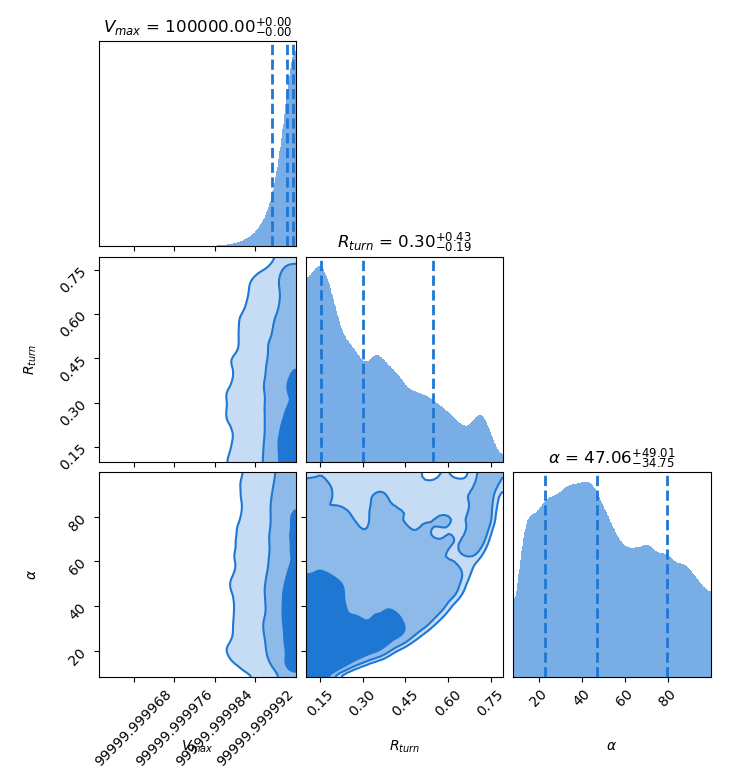

In [27]:
%matplotlib notebook

labels = ['$V_{max}$', '$R_{turn}$', r'$\alpha$']

nParams = len(labels)

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(nParams, nParams, figsize=(2.5*nParams, 2.6*nParams)),
                              color='#1f77d4')